In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Os dados foram previamente tratados no Power BI
#No Power BI existe um histórico de todas as alterações que foram realizadas

df = pd.read_csv('dados_tratados2.csv')
df = df.drop(columns=['id'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ano Desistência          793 non-null    int64  
 1   Cidade                   793 non-null    object 
 2   Coeficiente              793 non-null    float64
 3   Curso                    793 non-null    object 
 4   Escola Pública?          793 non-null    object 
 5   Estado                   793 non-null    object 
 6   Forma de Ingresso        793 non-null    object 
 7   Grupo (Étnico)           793 non-null    object 
 8   Idade                    793 non-null    int64  
 9   Nota Enem                793 non-null    float64
 10  Per. Ingresso            793 non-null    int64  
 11  Período Desistências     793 non-null    int64  
 12  Período do Aluno         793 non-null    int64  
 13  Sexo                     793 non-null    object 
 14  Situação Atual do Aluno  7

In [3]:
#aplicando label enconding em linhas binárias
label_cols = ['Sexo', 'Escola Pública?', 'Curso', 'Situação Atual do Aluno']
label_encoders = {}

for col in label_cols: 
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le #guardar o encoder caso seja necessário

In [4]:
#aplicando o One-hot Encondings em colunas com dados categóricos sem ordem fixa
one_hot_cols = ['Cidade', 'Estado', 'Forma de Ingresso', 'Grupo (Étnico)', 'Tipo de Cota']
df = pd.get_dummies(df, columns = one_hot_cols, drop_first = True) #O drop_first evita multicolinearidade 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Columns: 177 entries, Ano Desistência to Tipo de Cota_Cotista
dtypes: bool(166), float64(2), int32(4), int64(5)
memory usage: 184.4 KB


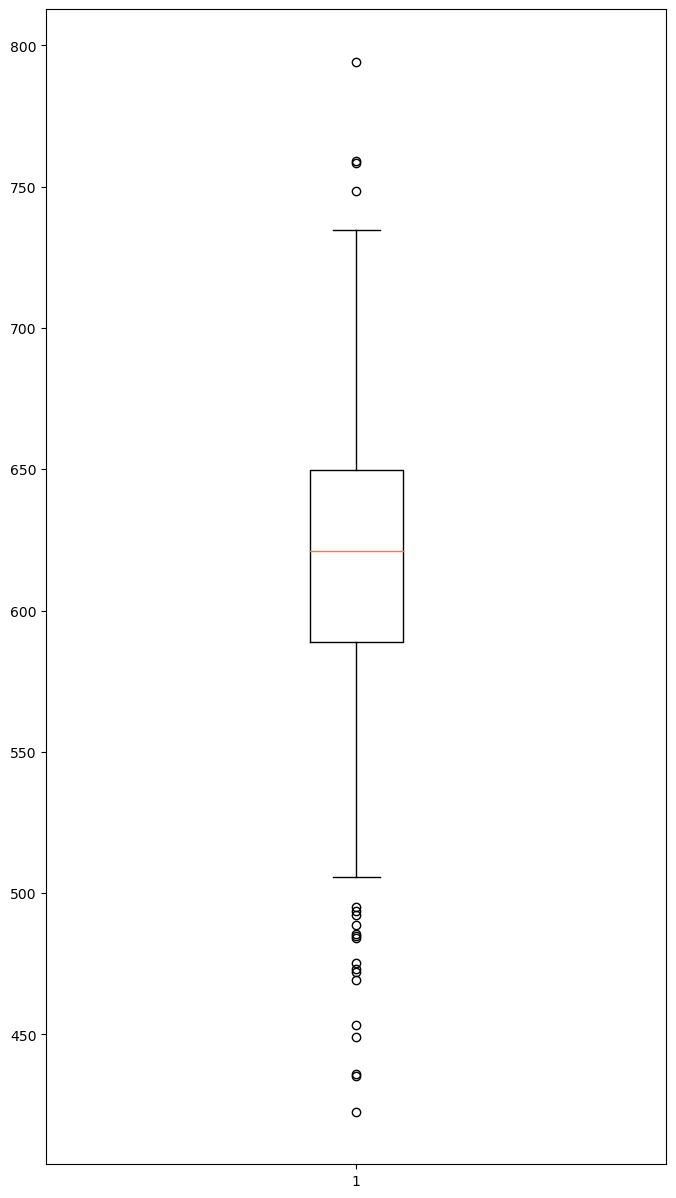

In [6]:
# Gerando o boxplot para a coluna Nota Enem
fig, ax = plt.subplots(figsize=(8,15))

ax.boxplot(df['Nota Enem'])

plt.show()

In [7]:
print(df['Curso'].unique())
print(df['Situação Atual do Aluno'].unique())

[0 1]
[0 1]


In [8]:
#Separando bases em base de teste e base de treino.

X = df.drop(columns=['Situação Atual do Aluno'])
y = df['Situação Atual do Aluno']

# Aplicar SMOTE para balancear as classes aumentando a classe minoritária
#smote = SMOTE(sampling_strategy="auto", random_state=42)
#X, y = smote.fit_resample(X, y)

#Aqui apaga-se dados da classe majoritária de forma aleatória até alcançar o balancemento.
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = rus.fit_resample(X, y)

print(X.info())
print(y.info())
print(y.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 563 to 788
Columns: 176 entries, Ano Desistência to Tipo de Cota_Cotista
dtypes: bool(166), float64(2), int32(3), int64(5)
memory usage: 78.9 KB
None
<class 'pandas.core.series.Series'>
Index: 334 entries, 563 to 788
Series name: Situação Atual do Aluno
Non-Null Count  Dtype
--------------  -----
334 non-null    int32
dtypes: int32(1)
memory usage: 3.9 KB
None
Situação Atual do Aluno
0    167
1    167
Name: count, dtype: int64


In [9]:
#Separação das bases  para método de avaliação holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando uma cópia para normalização apenas na Regressão Logística
#OBS: Os modelos Random Forest e Extra Trees não precisam de dados normalizados pois são baseados em árcores de decisão
X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

# Aplicando normalização APENAS para a Regressão Logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Criando o pipeline para Logistic Regression
logistic_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Normaliza os dados
    ("model", LogisticRegression(random_state=42, max_iter=10000))
])

In [11]:
#Teste com modelos de classificação

# Definindo os modelos de classificação
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=10000)
}

Avaliação Holdout para Random Forest:
Acurácia: 0.9801980198019802
Precisão: 0.9795918367346939
Recall: 0.9795918367346939
F1-score: 0.9795918367346939
--------------------------------------------------


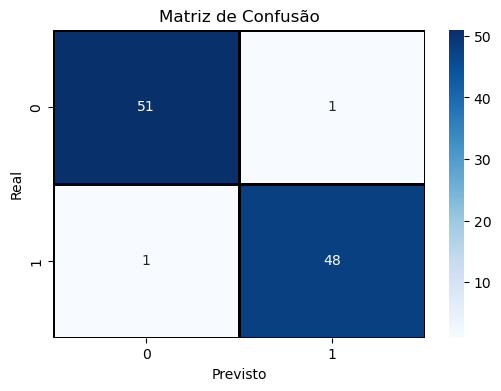

Avaliação Holdout para Extra Trees:
Acurácia: 0.9801980198019802
Precisão: 0.9607843137254902
Recall: 1.0
F1-score: 0.98
--------------------------------------------------


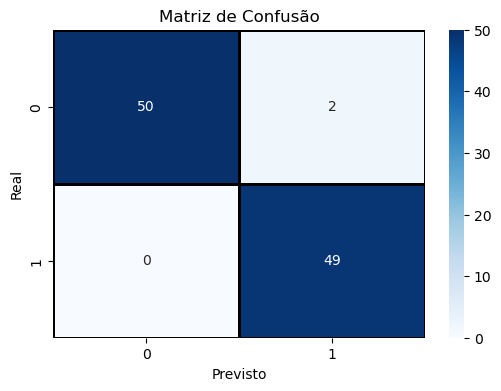

Avaliação Holdout para Logistic Regression:
Acurácia: 0.9900990099009901
Precisão: 0.98
Recall: 1.0
F1-score: 0.98989898989899
--------------------------------------------------


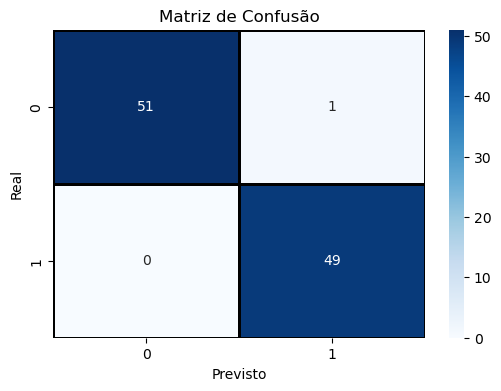

In [12]:
# Avaliação holdout para cada modelo
for model_name, model in models.items():
    print(f"Avaliação Holdout para {model_name}:")
    
    # Treinando o modelo e fazendo previsão
    if model_name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)  # Usa os dados normalizados
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)  # Usa os dados originais
        y_pred = model.predict(X_test)
    
    # Calculando métricas de classificação
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Exibindo os resultados
    print("Acurácia:", accuracy)
    print("Precisão:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("-" * 50)
    
    #Matriz de confusão
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor="black")

    # Labels e título
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()


In [13]:
# Validação Cruzada para cada modelo
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Validação Cruzada para {model_name}:")
    
    # Calculando a acurácia para cada fold
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print("Acurácia para cada fold:", accuracy_scores)
    print("Média da Acurácia:", accuracy_scores.mean())
    print("Desvio padrão da Acurácia:", accuracy_scores.std())
    
    # Calculando o F1-score para cada fold
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    print("F1-score para cada fold:", f1_scores)
    print("Média do F1-score:", f1_scores.mean())
    print("Desvio padrão do F1-score:", f1_scores.std())
    print("-" * 50)

Validação Cruzada para Random Forest:
Acurácia para cada fold: [0.98507463 0.95522388 1.         0.97014925 0.98484848]
Média da Acurácia: 0.9790592492085028
Desvio padrão da Acurácia: 0.015203472482388354
F1-score para cada fold: [0.98507463 0.95238095 1.         0.97222222 0.98630137]
Média do F1-score: 0.9791958342663719
Desvio padrão do F1-score: 0.016034533394422814
--------------------------------------------------
Validação Cruzada para Extra Trees:
Acurácia para cada fold: [0.97014925 0.95522388 0.97014925 0.97014925 0.96969697]
Média da Acurácia: 0.9670737222976029
Desvio padrão da Acurácia: 0.005927509697116571
F1-score para cada fold: [0.97058824 0.95238095 0.97058824 0.97222222 0.97297297]
Média do F1-score: 0.9677505236328766
Desvio padrão do F1-score: 0.007740788083864496
--------------------------------------------------
Validação Cruzada para Logistic Regression:
Acurácia para cada fold: [0.98507463 0.94029851 1.         0.97014925 0.96969697]
Média da Acurácia: 0.97304